# RHEED Metrics with Details

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../../src/')

import os
import re
import numpy as np
import matplotlib.pyplot as plt

from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.util.file_IO import download_and_unzip
from m3_learning.viz.printing import printer
from m3_learning.RHEED.Dataset import RHEED_spot_Dataset, RHEED_parameter_dataset
from m3_learning.RHEED.Viz import Viz
from m3_learning.RHEED.Fit import RHEED_image_processer, Gaussian

printing_image = printer(basepath = 'Figures/1.Fit_RHEED_spot/')
printing_plot = printer(basepath = 'Figures/1.Fit_RHEED_spot/', fileformats=['png'])

set_style("printing")
random_seed(seed=42)

2023-06-07 10:47:51.138154: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-07 10:47:51.731153: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ferroelectric/micromamba/envs/m3-RHEED/lib/python3.10/site-packages/cv2/../../lib64:
2023-06-07 10:47:51.731203: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ferroelectric/micromamba/envs/m3-

printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


## 1. Download datasets from Zenodo

In [36]:
# Download the data file from Zenodo
download=False
if download:
    # full size version
    urls = ['https://zenodo.org/record/7950043/files/STO_STO_test6_06292022-standard.h5?download=1',
            'https://zenodo.org/record/7950043/files/STO_STO_test7_06292022-standard.h5?download=1',
            'https://zenodo.org/record/7950043/files/STO_STO_test9_07142022-standard.h5?download=1',
            'https://zenodo.org/record/7950043/files/test6_gaussian_fit_parameters_all-04232023.h5?download=1',
            'https://zenodo.org/record/7950043/files/test7_gaussian_fit_parameters_all-04232023.h5?download=1',
            'https://zenodo.org/record/7950043/files/test9_gaussian_fit_parameters_all-04232023.h5?download=1']

    # compressed version
    urls_compressed = ['https://zenodo.org/record/7948591/files/STO_STO_test6_06292022-standard-compressed.h5?download=1',
                        'https://zenodo.org/record/7948591/files/STO_STO_test7_06292022-standard-compressed.h5?download=1',
                        'https://zenodo.org/record/7948591/files/STO_STO_test9_07142022-standard-compressed.h5?download=1',
                        'https://zenodo.org/record/7948591/files/test6_gaussian_fit_parameters_all-04232023-compressed.h5?download=1',
                        'https://zenodo.org/record/7948591/files/test7_gaussian_fit_parameters_all-04232023-compressed.h5?download=1',
                        'https://zenodo.org/record/7948591/files/test9_gaussian_fit_parameters_all-04232023-compressed.h5?download=1']   

    for url in urls:
        # Specify the filename and the path to save the file
        filename = re.split(r'\?', os.path.basename(url))[0]
        save_path = './../2023_RHEED_PLD_SrTiO3/Datasets/'

        # download the file
        download_and_unzip(filename, url, save_path)

## 2. Fitting the RHEED Dataset

### 2.1 Sample treated_213nm

#### 2.1.1 Loading the Dataset

In [2]:
path = './Datasets/STO_STO_test6_06292022-standard.h5'
D1_spot = RHEED_spot_Dataset(path, sample_name='treated_213nm')
D1_spot.data_info

Growth: background_with_heater, Size of data: f(2251, 300, 300)
Growth: background_without_heater, Size of data: f(2942, 300, 300)
Growth: growth_1, Size of data: f(13189, 300, 300)
Growth: growth_10, Size of data: f(12336, 300, 300)
Growth: growth_11, Size of data: f(12799, 300, 300)
Growth: growth_12, Size of data: f(12563, 300, 300)
Growth: growth_2, Size of data: f(12858, 300, 300)
Growth: growth_3, Size of data: f(11392, 300, 300)
Growth: growth_4, Size of data: f(13067, 300, 300)
Growth: growth_5, Size of data: f(12619, 300, 300)
Growth: growth_6, Size of data: f(12610, 300, 300)
Growth: growth_7, Size of data: f(12431, 300, 300)
Growth: growth_8, Size of data: f(12553, 300, 300)
Growth: growth_9, Size of data: f(12568, 300, 300)


#### 2.1.2 Locate the diffraction spots

Figures/1.Fit_RHEED_spot/RHEED_treated_213nm_growth_2_0.png
Figures/1.Fit_RHEED_spot/RHEED_treated_213nm_growth_2_0.svg
Fig. a: RHEED spot image for growth_2 at index 0.


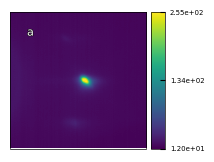

In [3]:
D1_spot.viz_RHEED_spot(growth='growth_2', index=0, figsize=(2,4), filename=True, printing=printing_image)

#### 2.1.3 Visualize an example

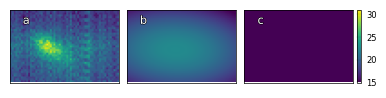

Fig. a: RHEED spot image, b: reconstructed RHEED spot image, c: difference between original and reconstructed image for growth_1 at index 0.
The Gaussian fitted parameters are: img_sum=48241.00, img_max=31.00, img_mean=20.10,
img_rec_sum=48030.96, img_rec_max=22.65, img_rec_mean=20.01,
height=22.65, x=22.31, y=26.81, width_x=30.30, width_y_max=57.73.


In [4]:
crop_dict = {'spot_1': [40, 80, 100, 160], 
             'spot_2': [137, 166, 147, 195], 
             'spot_3': [230, 262, 115, 180]}

fit_function = Gaussian().recreate_gaussian
processor = RHEED_image_processer(D1_spot, crop_dict, fit_function)
img, img_rec, parameters = processor.visualize(growth='growth_1', spot='spot_1', frame=0)

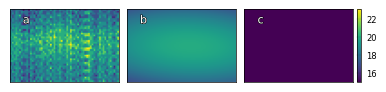

Fig. a: RHEED spot image, b: reconstructed RHEED spot image, c: difference between original and reconstructed image for growth_12 at index 0.
The Gaussian fitted parameters are: img_sum=45531.00, img_max=23.00, img_mean=18.97,
img_rec_sum=45440.48, img_rec_max=19.94, img_rec_mean=18.93,
height=19.94, x=20.29, y=34.92, width_x=42.13, width_y_max=114.21.


In [5]:
img, img_rec, parameters = processor.visualize(growth='growth_12', spot='spot_1', frame=0)

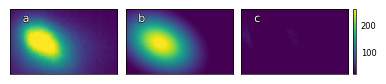

Fig. a: RHEED spot image, b: reconstructed RHEED spot image, c: difference between original and reconstructed image for growth_1 at index 0.
The Gaussian fitted parameters are: img_sum=120241.00, img_max=255.00, img_mean=86.38,
img_rec_sum=105894.35, img_rec_max=260.62, img_rec_mean=76.07,
height=260.95, x=17.81, y=19.75, width_x=7.32, width_y_max=10.65.


In [6]:
img, img_rec, parameters = processor.visualize(growth='growth_1', spot='spot_2', frame=0)

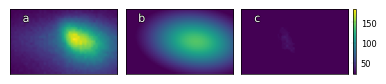

Fig. a: RHEED spot image, b: reconstructed RHEED spot image, c: difference between original and reconstructed image for growth_12 at index 0.
The Gaussian fitted parameters are: img_sum=87657.00, img_max=183.00, img_mean=62.97,
img_rec_sum=82424.84, img_rec_max=139.73, img_rec_mean=59.21,
height=139.78, x=14.58, y=31.86, width_x=8.56, width_y_max=14.55.


In [7]:
img, img_rec, parameters = processor.visualize(growth='growth_12', spot='spot_2', frame=0)

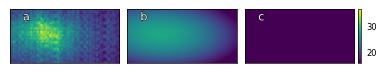

Fig. a: RHEED spot image, b: reconstructed RHEED spot image, c: difference between original and reconstructed image for growth_1 at index 0.
The Gaussian fitted parameters are: img_sum=47740.00, img_max=36.00, img_mean=22.95,
img_rec_sum=47200.00, img_rec_max=27.82, img_rec_mean=22.69,
height=27.83, x=14.75, y=19.52, width_x=21.56, width_y_max=47.67.


In [8]:
img, img_rec, parameters = processor.visualize(growth='growth_1', spot='spot_3', frame=0)

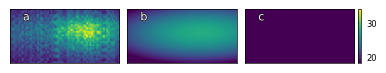

Fig. a: RHEED spot image, b: reconstructed RHEED spot image, c: difference between original and reconstructed image for growth_12 at index 0.
The Gaussian fitted parameters are: img_sum=49480.00, img_max=34.00, img_mean=23.79,
img_rec_sum=49086.48, img_rec_max=27.89, img_rec_mean=23.60,
height=27.90, x=13.87, y=44.06, width_x=20.56, width_y_max=62.86.


In [9]:
img, img_rec, parameters = processor.visualize(growth='growth_12', spot='spot_3', frame=0)

#### 2.1.4 Exam the dataset

In [10]:
path = './Datasets/test6_gaussian_fit_parameters_all-04232023.h5'
D1_para = RHEED_parameter_dataset(path, camera_freq=500, sample_name='treated_213nm')
# D1_para.data_info   

Figures/1.Fit_RHEED_spot/RHEED_treated_213nm_growth_2_spot_2_10000_img,img_rec,differerce.png
Figures/1.Fit_RHEED_spot/RHEED_treated_213nm_growth_2_spot_2_10000_img,img_rec,differerce.svg


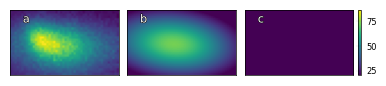

Fig. a: RHEED spot image, b: reconstructed RHEED spot image, c: difference between original and reconstructed image for growth_2 at index 10000.
img_sum=61247.00, img_max=87.00, img_mean=44.00
img_rec_sum=59368.68, img_rec_max=72.97, img_rec_mean=42.65
height=72.98, x=15.40, y=20.73, width_x=10.33, width_y_max=20.36


In [11]:
D1_para.viz_RHEED_parameter(growth='growth_2', spot='spot_2', index=10000, filename = True, printing=printing_image)

/home/ferroelectric/micromamba/envs/m3-RHEED/lib/python3.10/site-packages/m3_learning/RHEED/Dataset.py:414: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['' for tick in ax.get_xticks()])


Figures/1.Fit_RHEED_spot/RHEED_treated_213nm_spot_2_metrics.png


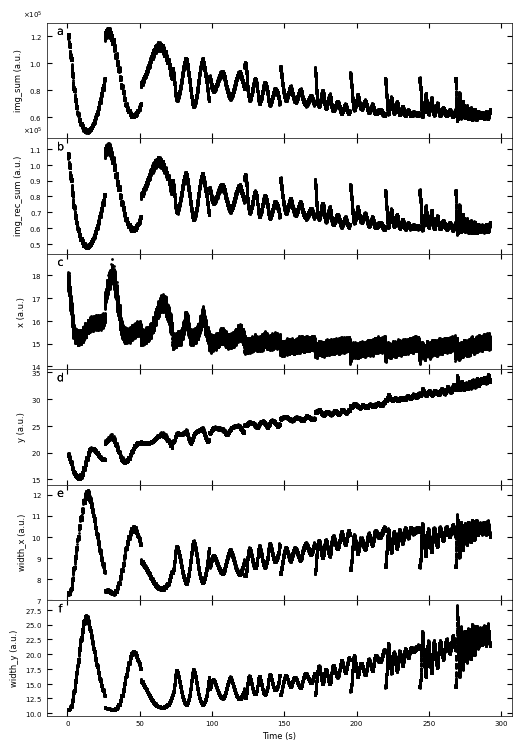

Gaussian fitted parameters in time: Fig. a: sum of original image, b: sum of reconstructed image, c: spot center in spot x coordinate, d: spot center in y coordinate, e: spot width in x coordinate, f: spot width in y coordinate.


In [12]:
growth_list = ['growth_1', 'growth_2', 'growth_3', 'growth_4', 'growth_5', 'growth_6', 
               'growth_7', 'growth_8', 'growth_9', 'growth_10', 'growth_11', 'growth_12']
D1_para.viz_RHEED_parameter_trend(growth_list, spot='spot_2', head_tail=(100,300), filename=True, printing=printing_plot)

### 2.2 Sample treated_81nm

#### 2.2.1 Loading the Dataset

In [13]:
path = './Datasets/STO_STO_test7_06292022-standard.h5'
D2_spot = RHEED_spot_Dataset(path, sample_name='treated_81nm')
D2_spot.data_info

Growth: background_with_heater, Size of data: f(2651, 300, 600)
Growth: background_without_heater, Size of data: f(2652, 300, 600)
Growth: growth_1, Size of data: f(8603, 300, 600)
Growth: growth_10, Size of data: f(9439, 300, 600)
Growth: growth_11, Size of data: f(12155, 300, 600)
Growth: growth_12, Size of data: f(10736, 300, 600)
Growth: growth_2, Size of data: f(10612, 300, 600)
Growth: growth_3, Size of data: f(11648, 300, 600)
Growth: growth_4, Size of data: f(12152, 300, 600)
Growth: growth_5, Size of data: f(12317, 300, 600)
Growth: growth_6, Size of data: f(12453, 300, 600)
Growth: growth_7, Size of data: f(9482, 300, 600)
Growth: growth_8, Size of data: f(9490, 300, 600)
Growth: growth_9, Size of data: f(9704, 300, 600)


#### 2.2.2 Locate the diffraction spots

Figures/1.Fit_RHEED_spot/RHEED_treated_81nm_growth_2_10.png
Figures/1.Fit_RHEED_spot/RHEED_treated_81nm_growth_2_10.svg
Fig. a: RHEED spot image for growth_2 at index 10.


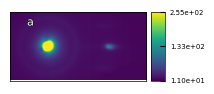

In [14]:
D2_spot.viz_RHEED_spot(growth='growth_2', index=10, figsize=(2,3), filename=True, printing=printing_image)

#### 2.2.3 Visualize an example

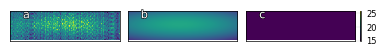

Fig. a: RHEED spot image, b: reconstructed RHEED spot image, c: difference between original and reconstructed image for growth_1 at index 1000.
The Gaussian fitted parameters are: img_sum=65540.00, img_max=26.00, img_mean=19.86,
img_rec_sum=65251.70, img_rec_max=21.53, img_rec_mean=19.77,
height=21.53, x=14.19, y=51.74, width_x=27.23, width_y_max=127.01.


In [15]:
crop_dict = {'spot_1': [50, 80, 340, 450], 'spot_2': [143, 165, 415, 455], 'spot_3': [220, 260, 340, 450]}
fit_function = Gaussian().recreate_gaussian
processor = RHEED_image_processer(D2_spot, crop_dict, fit_function)
img, img_rec, parameters = processor.visualize(growth='growth_1', spot='spot_1', frame=1000)

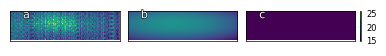

Fig. a: RHEED spot image, b: reconstructed RHEED spot image, c: difference between original and reconstructed image for growth_12 at index 1000.
The Gaussian fitted parameters are: img_sum=62861.00, img_max=26.00, img_mean=19.05,
img_rec_sum=62570.65, img_rec_max=20.62, img_rec_mean=18.96,
height=20.62, x=13.23, y=45.64, width_x=29.37, width_y_max=122.00.


In [16]:
img, img_rec, parameters = processor.visualize(growth='growth_12', spot='spot_1', frame=1000)

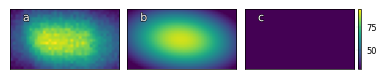

Fig. a: RHEED spot image, b: reconstructed RHEED spot image, c: difference between original and reconstructed image for growth_1 at index 1000.
The Gaussian fitted parameters are: img_sum=52423.00, img_max=94.00, img_mean=59.57,
img_rec_sum=51037.70, img_rec_max=89.54, img_rec_mean=58.00,
height=89.60, x=11.21, y=19.78, width_x=9.67, width_y_max=17.10.


In [17]:
img, img_rec, parameters = processor.visualize(growth='growth_1', spot='spot_2', frame=1000)

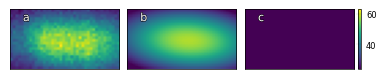

Fig. a: RHEED spot image, b: reconstructed RHEED spot image, c: difference between original and reconstructed image for growth_12 at index 1000.
The Gaussian fitted parameters are: img_sum=38092.00, img_max=63.00, img_mean=43.29,
img_rec_sum=37432.69, img_rec_max=58.39, img_rec_mean=42.54,
height=58.39, x=11.58, y=22.47, width_x=10.38, width_y_max=23.31.


In [18]:
img, img_rec, parameters = processor.visualize(growth='growth_12', spot='spot_2', frame=1000)

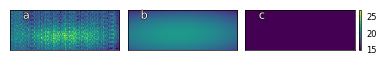

Fig. a: RHEED spot image, b: reconstructed RHEED spot image, c: difference between original and reconstructed image for growth_1 at index 1000.
The Gaussian fitted parameters are: img_sum=87305.00, img_max=27.00, img_mean=19.84,
img_rec_sum=87167.35, img_rec_max=21.47, img_rec_mean=19.81,
height=21.47, x=24.11, y=49.98, width_x=39.04, width_y_max=130.77.


In [19]:
img, img_rec, parameters = processor.visualize(growth='growth_1', spot='spot_3', frame=1000)

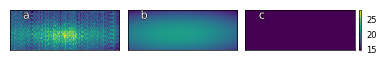

Fig. a: RHEED spot image, b: reconstructed RHEED spot image, c: difference between original and reconstructed image for growth_12 at index 1000.
The Gaussian fitted parameters are: img_sum=88520.00, img_max=28.00, img_mean=20.12,
img_rec_sum=88317.24, img_rec_max=22.32, img_rec_mean=20.07,
height=22.32, x=23.81, y=49.66, width_x=33.31, width_y_max=115.16.


In [20]:
img, img_rec, parameters = processor.visualize(growth='growth_12', spot='spot_3', frame=1000)

#### 2.2.4 Exam the dataset

In [21]:
path = './Datasets/test7_gaussian_fit_parameters_all-04232023.h5'
D2_para = RHEED_parameter_dataset(path, camera_freq=500, sample_name='treated_81nm')
# D2_para.data_info

Figures/1.Fit_RHEED_spot/RHEED_treated_81nm_growth_2_spot_2_10000_img,img_rec,differerce.png
Figures/1.Fit_RHEED_spot/RHEED_treated_81nm_growth_2_spot_2_10000_img,img_rec,differerce.svg


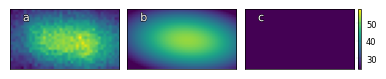

Fig. a: RHEED spot image, b: reconstructed RHEED spot image, c: difference between original and reconstructed image for growth_2 at index 10000.
img_sum=35031.00, img_max=58.00, img_mean=39.81
img_rec_sum=34451.97, img_rec_max=52.63, img_rec_mean=39.15
height=52.64, x=11.50, y=22.16, width_x=11.22, width_y_max=22.80


In [22]:
D2_para.viz_RHEED_parameter(growth='growth_2', spot='spot_2', index=10000, filename=True, printing=printing_image)

Figures/1.Fit_RHEED_spot/RHEED_treated_81nm_spot_2_metrics.png


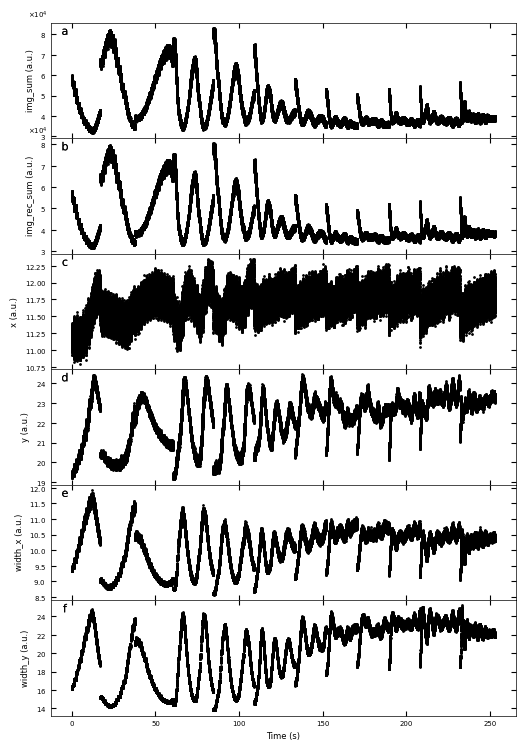

Gaussian fitted parameters in time: Fig. a: sum of original image, b: sum of reconstructed image, c: spot center in spot x coordinate, d: spot center in y coordinate, e: spot width in x coordinate, f: spot width in y coordinate.


In [23]:
growth_list = ['growth_1', 'growth_2', 'growth_3', 'growth_4', 'growth_5', 'growth_6', 'growth_7', 'growth_8', 'growth_9', 'growth_10', 'growth_11', 'growth_12']
D2_para.viz_RHEED_parameter_trend(growth_list, spot='spot_2', filename=True, printing=printing_plot)

### 2.3 Sample untreated_162nm

#### 2.3.1 Loading the Dataset

In [24]:
path = './Datasets/STO_STO_test9_07142022-standard.h5'
D3_spot = RHEED_spot_Dataset(path, sample_name='untreated_162nm')
# D3_spot.data_info

#### 2.3.2 Locate the diffraction spots

Figures/1.Fit_RHEED_spot/RHEED_untreated_162nm_growth_2_0.png
Figures/1.Fit_RHEED_spot/RHEED_untreated_162nm_growth_2_0.svg
Fig. a: RHEED spot image for growth_2 at index 0.


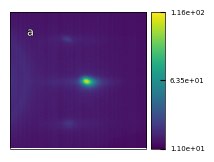

In [25]:
D3_spot.viz_RHEED_spot(growth='growth_2', index=0, figsize=(2,4),  filename=True, printing=printing_image)

#### 2.3.3 Visualize an example

In [26]:
# sets where to crop the image to extact the peaks
crop_dict = {'spot_1': [50, 72, 100, 150], 'spot_2': [143, 162, 150, 190], 'spot_3': [218, 262, 100, 165]}
fit_function = Gaussian().recreate_gaussian
processor = RHEED_image_processer(D3_spot, crop_dict, fit_function)

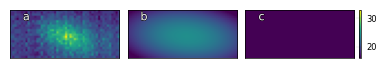

Fig. a: RHEED spot image, b: reconstructed RHEED spot image, c: difference between original and reconstructed image for growth_1 at index 1000.
The Gaussian fitted parameters are: img_sum=23046.00, img_max=33.00, img_mean=20.95,
img_rec_sum=22881.26, img_rec_max=24.39, img_rec_mean=20.80,
height=24.39, x=12.31, y=26.93, width_x=16.87, width_y_max=36.30.


In [27]:
img, img_rec, parameters = processor.visualize(growth='growth_1', spot='spot_1', frame=1000)

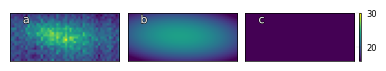

Fig. a: RHEED spot image, b: reconstructed RHEED spot image, c: difference between original and reconstructed image for growth_18 at index 1000.
The Gaussian fitted parameters are: img_sum=22782.00, img_max=30.00, img_mean=20.71,
img_rec_sum=22540.11, img_rec_max=23.95, img_rec_mean=20.49,
height=23.95, x=10.74, y=23.69, width_x=15.40, width_y_max=40.17.


In [28]:
img, img_rec, parameters = processor.visualize(growth='growth_18', spot='spot_1', frame=1000)

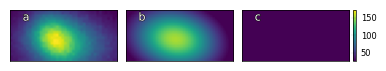

Fig. a: RHEED spot image, b: reconstructed RHEED spot image, c: difference between original and reconstructed image for growth_1 at index 1000.
The Gaussian fitted parameters are: img_sum=58629.00, img_max=172.00, img_mean=77.14,
img_rec_sum=56051.32, img_rec_max=152.96, img_rec_mean=73.75,
height=153.25, x=11.26, y=18.91, width_x=7.66, width_y_max=11.11.


In [29]:
img, img_rec, parameters = processor.visualize(growth='growth_1', spot='spot_2', frame=1000)

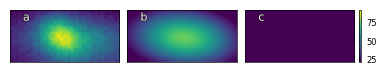

Fig. a: RHEED spot image, b: reconstructed RHEED spot image, c: difference between original and reconstructed image for growth_18 at index 1000.
The Gaussian fitted parameters are: img_sum=35114.00, img_max=92.00, img_mean=46.20,
img_rec_sum=33973.47, img_rec_max=75.65, img_rec_mean=44.70,
height=75.75, x=10.23, y=20.99, width_x=7.94, width_y_max=14.74.


In [30]:
img, img_rec, parameters = processor.visualize(growth='growth_18', spot='spot_2', frame=1000)

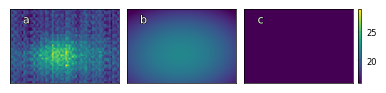

Fig. a: RHEED spot image, b: reconstructed RHEED spot image, c: difference between original and reconstructed image for growth_1 at index 1000.
The Gaussian fitted parameters are: img_sum=56802.00, img_max=29.00, img_mean=19.86,
img_rec_sum=56669.50, img_rec_max=21.97, img_rec_mean=19.81,
height=21.97, x=26.85, y=31.92, width_x=40.82, width_y_max=61.30.


In [31]:
img, img_rec, parameters = processor.visualize(growth='growth_1', spot='spot_3', frame=1000)

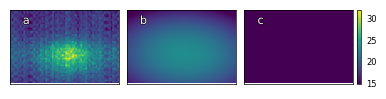

Fig. a: RHEED spot image, b: reconstructed RHEED spot image, c: difference between original and reconstructed image for growth_18 at index 1000.
The Gaussian fitted parameters are: img_sum=57391.00, img_max=32.00, img_mean=20.07,
img_rec_sum=57205.76, img_rec_max=23.31, img_rec_mean=20.00,
height=23.31, x=26.83, y=34.85, width_x=31.40, width_y_max=54.38.


In [32]:
img, img_rec, parameters = processor.visualize(growth='growth_18', spot='spot_3', frame=1000)

#### 2.3.4 Examine the dataset

In [33]:
path = './Datasets/test9_gaussian_fit_parameters_all-04232023.h5'
D3_para = RHEED_parameter_dataset(path, camera_freq=500, sample_name='untreated_162nm')
D3_para.data_info

Growth: background_with_heater:
--spot: spot_1:
----height:, Size of data: (2023,)
----height:, Size of data: (2023,)
----img_max:, Size of data: (2023,)
----img_max:, Size of data: (2023,)
----img_mean:, Size of data: (2023,)
----img_mean:, Size of data: (2023,)
----img_rec_max:, Size of data: (2023,)
----img_rec_max:, Size of data: (2023,)
----img_rec_mean:, Size of data: (2023,)
----img_rec_mean:, Size of data: (2023,)
----img_rec_sum:, Size of data: (2023,)
----img_rec_sum:, Size of data: (2023,)
----img_sum:, Size of data: (2023,)
----img_sum:, Size of data: (2023,)
----raw_image:, Size of data: (2023, 22, 50)
----raw_image:, Size of data: (2023, 22, 50)
----reconstructed_image:, Size of data: (2023, 22, 50)
----reconstructed_image:, Size of data: (2023, 22, 50)
----width_x:, Size of data: (2023,)
----width_x:, Size of data: (2023,)
----width_y:, Size of data: (2023,)
----width_y:, Size of data: (2023,)
----x:, Size of data: (2023,)
----x:, Size of data: (2023,)
----y:, Size of da

Figures/1.Fit_RHEED_spot/RHEED_untreated_162nm_growth_2_spot_2_100_img,img_rec,differerce.png
Figures/1.Fit_RHEED_spot/RHEED_untreated_162nm_growth_2_spot_2_100_img,img_rec,differerce.svg


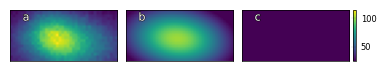

Fig. a: RHEED spot image, b: reconstructed RHEED spot image, c: difference between original and reconstructed image for growth_2 at index 100.
img_sum=45893.00, img_max=114.00, img_mean=60.39
img_rec_sum=44505.52, img_rec_max=101.14, img_rec_mean=58.56
height=101.29, x=10.95, y=19.21, width_x=8.27, width_y_max=13.94


In [34]:
D3_para.viz_RHEED_parameter(growth='growth_2', spot='spot_2', index=100, filename=True, printing=printing_image)

Figures/1.Fit_RHEED_spot/RHEED_untreated_162nm_spot_2_metrics.png


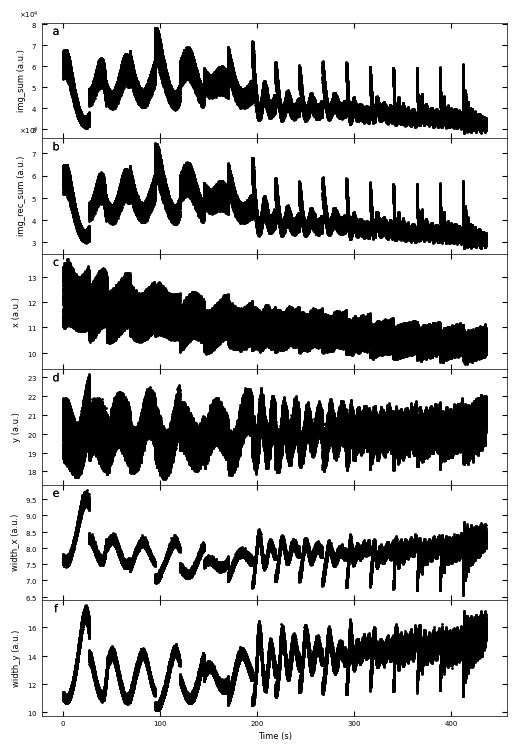

Gaussian fitted parameters in time: Fig. a: sum of original image, b: sum of reconstructed image, c: spot center in spot x coordinate, d: spot center in y coordinate, e: spot width in x coordinate, f: spot width in y coordinate.


In [35]:
growth_list = ['growth_1', 'growth_2', 'growth_3', 'growth_4', 'growth_5', 'growth_6', 'growth_7', 'growth_8', 'growth_9', 
               'growth_10', 'growth_11', 'growth_12' , 'growth_13', 'growth_14', 'growth_15', 'growth_16', 'growth_17', 'growth_18']
D3_para.viz_RHEED_parameter_trend(growth_list, spot='spot_2', filename=True, printing=printing_plot)